# Cmpe 548 Monte Carlo Methods Assignment 2

**Alper Ahmetoğlu 2012400147**

### 1. Importance Sampling (unfinished)

In [123]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

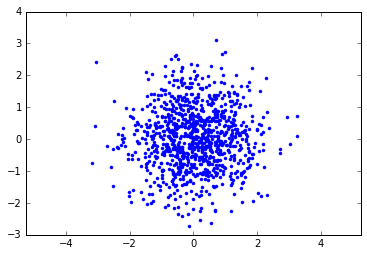

In [124]:
N = 1000
p = 0.5

def pnorm(x,y,p):
    if np.power((np.power(np.absolute(x),p) + np.power(np.absolute(y),p)),1/p) <= 1:
        return (x,y)

r1 = np.random.randn(N)
r2 = np.random.randn(N)

v_pnorm = np.vectorize(pnorm)

a = v_pnorm(r1,r2,1)

#a = pnorm(r1,r2,p)

plt.plot(r1,r2,'.b')
plt.axis('equal');

### 2. Markov Chains

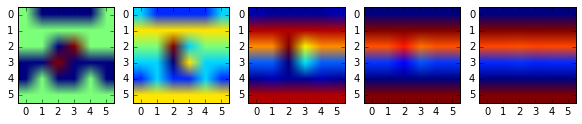

In [164]:
# Transition matrix

A = [[0.25, 0,    0,    0,    0,    0.25],
     [0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
     [0.25, 0.25, 0,    0.5,  0.25, 0.25],
     [0,    0,    0.5,  0,    0,    0   ],
     [0,    0.25, 0,    0,    0.25, 0   ],
     [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]]

# Initial configuration
X_0 = [1,0,0,0,0,0]

X_2 = np.linalg.matrix_power(A,2)         # X_2 = T^2 * X_0
X_2 = np.linalg.matrix_power(A,2)         # X_2 = T^2 * X_0
X_4 = np.linalg.matrix_power(A,4)         # X_4 = T^4 * X_0
X_6 = np.linalg.matrix_power(A,6)         # X_6 = T^6 * X_0
X_10 = np.linalg.matrix_power(A,9)       # X_10 = T^10 * X_0

fig = plt.figure(figsize=(10,5))

a=fig.add_subplot(1,5,1)
plt.imshow(A)

a=fig.add_subplot(1,5,2)
plt.imshow(X_2);

a=fig.add_subplot(1,5,3)
plt.imshow(X_4);

a=fig.add_subplot(1,5,4)
plt.imshow(X_6);

a=fig.add_subplot(1,5,5)
plt.imshow(X_10);



In [116]:
# Eigenvector corresponding to lambda_1 = 1
v_1 = np.transpose(np.linalg.eig(A)[1])[0]
print(v_1 / sum(v_1) )

[ 0.08333333  0.25        0.22222222  0.11111111  0.08333333  0.25      ]


***Detailed Balance Condition***

This process does not satify *detailed balance conditon* since $T(x \mid x')\, \pi (x') = T(x' \mid x)\, \pi (x)$ condition does not hold. Some state transitions have one direction. For example there is a state transition from state 1 to state 3 but the opposite does not exist.